Ce notebook reprend le même problème que le notebook précédent, mais utilisera une approche deep learning.
On créera un réseau de neurones profond composé de 2 couches cachées comportant 128 et 256 neurones.

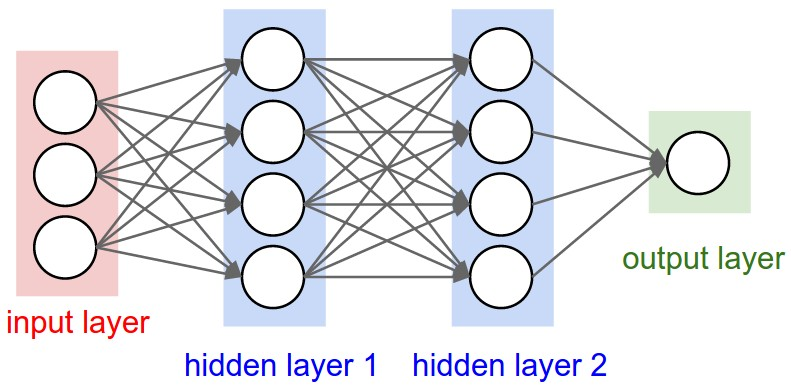

Commençons par importer les librairies nécessaires.

In [29]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

On définit nos variables globales

In [39]:
# Paramètres du dataset MNIST
num_classes = 10 # 10 chiffres -> 10 classes
num_features = 784 # 28*28 pixels

# Paramètres d'entraînement du modèle
learning_rate = 0.1
training_steps = 2000
batch_size = 256
display_step = 100

# Paramètres du réseau de neurones
n_hidden_1 = 128 # Nombre de neurones dans la première couche cachée
n_hidden_2 = 256 # Nombre de neurones dans la deuxième couche cachée

On load notre dataset ...

In [31]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

... et on attaque le préprocessing. Comme ces fonctions sont les mêmes que ceux du notebook précédent, on ne vous demande pas de les refaire.

In [32]:
# Conversion en type float
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten en un vecteur de 784 
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalisation
x_train, x_test = x_train / 255., x_test / 255.

Shuffle et batch.

In [33]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

Maintenant que nos jeux de données sont propres et prêts, on va pouvoir passer à notre modèle. Pour rappel, on souhaite créer une réseau de neurones profond composé de 4 couches donc 2 couches cachées contenant respectivement n_hidden_1 et n_hidden_2 neurones.

**Exerice**: Créez les couches de neurones ci-dessous en respectant les paramètres suivant:
    - fc1 contient n_hidden_1 neurones et utilisera la fonction d'activation ReLU
    - fc2 contient n_hidden_2 neurones et utilisera la fonction d'activation ReLU
    - out contient num_classes neurones et utilisera la fonction d'activation softmax (si vous ne savez toujours pas pourquoi softmax, posez-nous la question :))

**Indice**: la fonction Dense peut s'avérer très utile https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense   

In [65]:
# Création du modèle tensorflow
class NeuralNet(Model):
    # Définissez vos couches
    def __init__(self):
        super(NeuralNet, self).__init__()
        ### Début du code ###
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        self.out = layers.Dense(num_classes, activation=tf.nn.softmax)
        ### Fin du code ###

    # Forward propagation
    def call(self, x, is_training=False):
        x = self.out(x)
        if not is_training:
            # le softmax ne doit être appliqué qu'à la sortie et non pendant l'entraînement
            x = tf.nn.softmax(x)
        return x

On définit la fonction de loss cross entropy. On utilisera https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits.

In [66]:
# Cross Entropy Loss
def cross_entropy_loss(x, y):
    # Conversion des labels en int64 pour la fonction cross-entropy (voir la doc)
    y = tf.cast(y, tf.int64)

    # Calcul de la cross-entropy avec la fonction de tf
    ### Début du code ###
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    ### Fin du code ###
    # Retourne la moyenne des loss
    return tf.reduce_mean(loss)

Le définit la fonction accuracy pour vérifier la pertinence de notre modèle.

In [67]:
def accuracy(y_pred, y_true):
    # La classe prédite est celle dont l'index a le plus haut score dans y_pred
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

Optimisation du code grâce à la différenciation automatique

In [72]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = neural_net(x, is_training=True)
        loss = cross_entropy_loss(pred, y)
        
    # Variables à update, i.e. tf.trainable_variables.
    trainable_variables = neural_net.trainable_variables
    # Calcul des gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # Update de W et b en fonction des gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Maintenant que toutes les fonctions et la classe NeuralNet ont été initialisées, on peut passer à l'entraînement.
On commence par créer l'objet de type NeuralNet, puis on définit notre optimiseur, enfin on lance notre entraînement par batch.

In [74]:
neural_net = NeuralNet()

# Descente de gradient stochastique.
optimizer = tf.optimizers.SGD(learning_rate)

# Lancement de l'entraînement
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 2.060119, accuracy: 0.519531
step: 200, loss: 1.960343, accuracy: 0.582031
step: 300, loss: 1.919946, accuracy: 0.601562
step: 400, loss: 1.809587, accuracy: 0.742188
step: 500, loss: 1.786528, accuracy: 0.742188
step: 600, loss: 1.749921, accuracy: 0.777344
step: 700, loss: 1.723202, accuracy: 0.808594
step: 800, loss: 1.776026, accuracy: 0.738281
step: 900, loss: 1.749896, accuracy: 0.769531
step: 1000, loss: 1.757922, accuracy: 0.746094
step: 1100, loss: 1.698629, accuracy: 0.804688
step: 1200, loss: 1.702843, accuracy: 0.792969
step: 1300, loss: 1.700012, accuracy: 0.789062
step: 1400, loss: 1.665805, accuracy: 0.851562
step: 1500, loss: 1.676915, accuracy: 0.816406
step: 1600, loss: 1.667495, accuracy: 0.835938
step: 1700, loss: 1.642933, accuracy: 0.867188
step: 1800, loss: 1.709515, accuracy: 0.769531
step: 1900, loss: 1.685061, accuracy: 0.824219
step: 2000, loss: 1.716632, accuracy: 0.773438


Comme d'hab, on vérifie la pertinence de notre modèle avec le dataset de test

In [75]:
pred = neural_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.822400


Super, pas d'overfitting ^^. Si vous voulez visualiser vos prédictions, changez test_images comme vous le souhaitez.

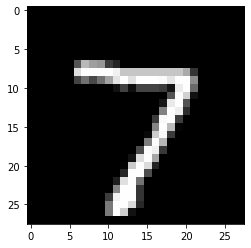

Model prediction: 7


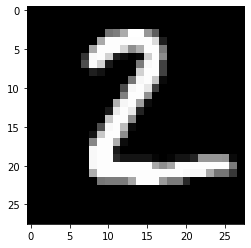

Model prediction: 2


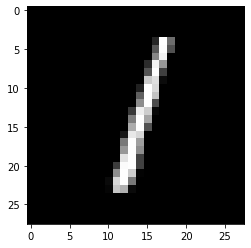

Model prediction: 1


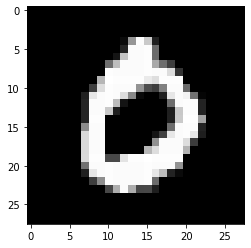

Model prediction: 0


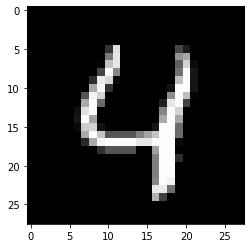

Model prediction: 4


In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

Bravo ! Encore un notebook fini !
Pour résumer, dans le notebook précédent, vous avez implémenté un modèle de machine learning avec Tensorflow. Ce n'était pas l'étape la plus simple puisque vous avez dû implémenter manuellement d'autres fonctions. 
Aujourd'hui, vous avez pu utiliser directement les fonctions de Tensorflow ce qui vous a permis de créer un modèle plus rapidement. 
Maintenant, vous êtes prêts à utiliser directement l'API de niveau encore plus haut: Keras. Suivez le tutoriel suivant pour en savoir plus: https://www.tensorflow.org/tutorials/quickstart/beginner